In [21]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

# === CONFIG ===
API_KEY = "HWcUpDjxioktguMmYs3GnIgR1MqpzQP7"
BASE_URL = "https://api.polygon.io"
TICKERS = ['BTC', 'ETH', 'SOL', 'XRP', 'ADA', 'DOGE', 'MATIC', 'DOT', 'LTC', 'BCH', 'TRX', 'LINK', 'AVAX', 'UNI']
TOP_N = 10
LOOKBACK_DAYS = 7

# === DATES ===
end_date = datetime.today() - timedelta(days=2)  # buffer for data delay
start_date = end_date - timedelta(days=LOOKBACK_DAYS)
date_from = start_date.strftime("%Y-%m-%d")
date_to = end_date.strftime("%Y-%m-%d")

# === FUNCTIONS ===
def fetch_agg_data(ticker):
    symbol = f"X:{ticker}USD"
    url = f"{BASE_URL}/v2/aggs/ticker/{symbol}/range/1/day/{date_from}/{date_to}?adjusted=true&sort=asc&apiKey={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"[ERROR] {ticker} - {response.status_code}: {response.text}")
        return None
    data = response.json().get("results", [])
    if not data:
        print(f"[WARN] No data returned for {ticker}")
        return None

    try:
        avg_price = sum(day['c'] for day in data) / len(data)
        avg_volume = sum(day['v'] for day in data) / len(data)
        weight = avg_price * avg_volume
        return {
            "Ticker": ticker,
            "Avg_Price": avg_price,
            "Avg_Volume": avg_volume,
            "Weight": weight
        }
    except Exception as e:
        print(f"[ERROR] Failed to process data for {ticker}: {e}")
        return None

# === MAIN ===
results = []
for ticker in TICKERS:
    print(f"[INFO] Fetching data for {ticker}...")
    data = fetch_agg_data(ticker)
    if data:
        results.append(data)
    time.sleep(15)  # increased sleep to reduce rate limiting

# === OUTPUT ===
df = pd.DataFrame(results)
df = df.sort_values(by="Weight", ascending=False).head(TOP_N).reset_index(drop=True)

print("\n--- Provisional Index (Top N Tokens) ---")
print(df)

# Save to CSV
df.to_csv("provisional_crypto_index.csv", index=False)
print("\n[✔] Index saved to 'provisional_crypto_index.csv'")


[INFO] Fetching data for BTC...
[INFO] Fetching data for ETH...
[INFO] Fetching data for SOL...
[INFO] Fetching data for XRP...
[INFO] Fetching data for ADA...
[INFO] Fetching data for DOGE...
[INFO] Fetching data for MATIC...
[INFO] Fetching data for DOT...
[INFO] Fetching data for LTC...
[INFO] Fetching data for BCH...
[INFO] Fetching data for TRX...
[INFO] Fetching data for LINK...
[INFO] Fetching data for AVAX...
[INFO] Fetching data for UNI...

--- Provisional Index (Top N Tokens) ---
  Ticker      Avg_Price    Avg_Volume        Weight
0    BTC  108186.620000  5.399025e+03  5.841023e+08
1    ETH    2519.008750  1.032759e+05  2.601529e+08
2    XRP       2.227272  6.984103e+07  1.555550e+08
3    SOL     150.887500  7.327420e+05  1.105616e+08
4   DOGE       0.166585  2.262680e+08  3.769285e+07
5    ADA       0.576238  3.946102e+07  2.273896e+07
6   LINK      13.388625  1.184589e+06  1.586001e+07
7    LTC      86.945000  1.321466e+05  1.148949e+07
8    UNI       7.205375  1.274550e+06

[INFO] Using static list of 24 tokens with active futures.

[✔] Filtered hedgeable index saved to 'data/hedgeable_crypto_index.csv'


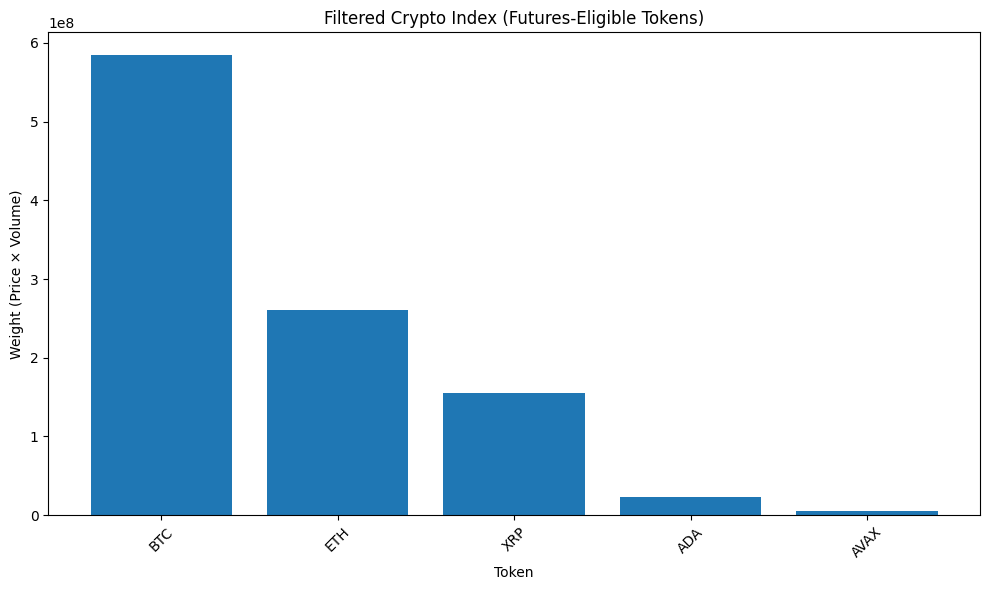

[✔] Chart saved to 'charts/index_plot.png'


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === STEP 1: Load your provisional index from CSV ===
try:
    df = pd.read_csv("provisional_crypto_index.csv")
except FileNotFoundError:
    print("[❌ ERROR] File 'provisional_crypto_index.csv' not found. Please run Step 1 first.")
    exit()

# === STEP 2: Use static list of tokens with active futures ===
def get_tokens_with_futures_static():
    known_futures_tokens = {
        "BTC", "ETH", "BNB", "XRP", "SOL", "ADA", "DOGE", "MATIC",
        "DOT", "LTC", "TRX", "AVAX", "LINK", "UNI", "BCH", "FIL",
        "ETC", "NEAR", "OP", "ARB", "APT", "ATOM", "SUI", "INJ"
    }
    print(f"[INFO] Using static list of {len(known_futures_tokens)} tokens with active futures.")
    return known_futures_tokens

futures_tokens = get_tokens_with_futures_static()

# === STEP 3: Optional ticker normalization ===
SYMBOL_FIX = {
    "DOGE": "DOGECOIN",
    "LINK": "CHAINLINK",
    "UNI": "UNISWAP",
    "XRP": "XRP",
    "AVAX": "AVAX",
    "TRX": "TRX",
    "SOL": "SOLANA",
    "ADA": "ADA",
    "DOT": "POLKADOT",
    "LTC": "LITECOIN",
    "BTC": "BTC",
    "ETH": "ETH",
    "BNB": "BNB",
    "FIL": "FILECOIN",
    "ETC": "ETC",
    "NEAR": "NEAR",
    "OP": "OPTIMISM",
    "ARB": "ARBITRUM",
    "APT": "APTOS",
    "ATOM": "COSMOS",
    "SUI": "SUI",
    "INJ": "INJECTIVE",
    "BCH": "BCH",
    "MATIC": "MATIC"
}
df["Mapped_Ticker"] = df["Ticker"].replace(SYMBOL_FIX)

# === STEP 4: Filter to tokens with futures ===
df_futures = df[df["Mapped_Ticker"].isin(futures_tokens)].reset_index(drop=True)

# === STEP 5: Save the final filtered index ===
os.makedirs("data", exist_ok=True)
df_futures.to_csv("data/hedgeable_crypto_index.csv", index=False)
print("\n[✔] Filtered hedgeable index saved to 'data/hedgeable_crypto_index.csv'")

# === STEP 6: Plot the index weights ===
if not df_futures.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df_futures["Ticker"], df_futures["Weight"])
    plt.title("Filtered Crypto Index (Futures-Eligible Tokens)")
    plt.xlabel("Token")
    plt.ylabel("Weight (Price × Volume)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Create charts folder and save
    os.makedirs("charts", exist_ok=True)
    plt.savefig("charts/index_plot.png")
    plt.show()
    print("[✔] Chart saved to 'charts/index_plot.png'")
else:
    print("\n[!] No tokens matched the static futures list. Index is empty.")


[✔] Saved BTC price data.
[✔] Saved ETH price data.
[✔] Saved XRP price data.
[✔] Saved ADA price data.
[✔] Saved AVAX price data.
[✔] Index time series saved to 'index_timeseries.csv'


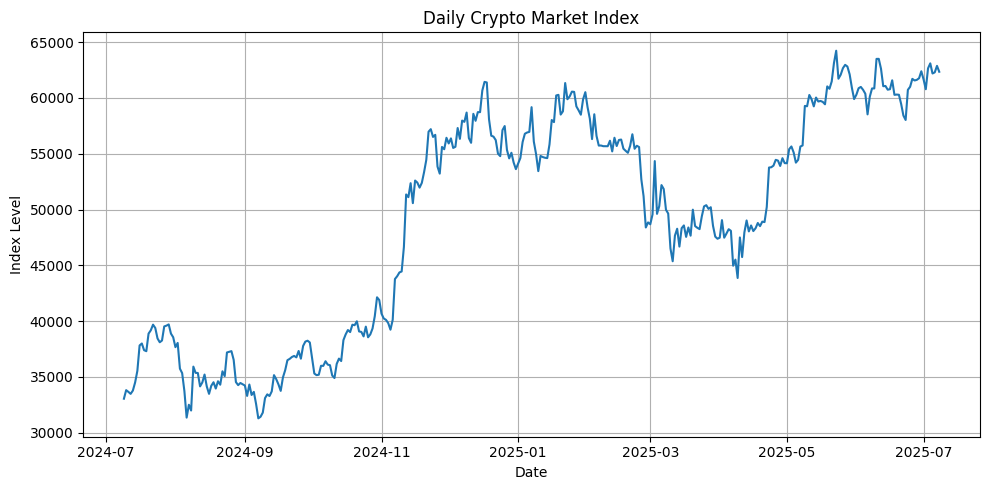

In [24]:
# Build Index Time Series from Token Prices and Static Weights

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time

# === Step 1: Download historical daily prices from CoinGecko ===
def fetch_coingecko_prices(token_id, vs_currency="usd", days="365"):
    url = f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart?vs_currency={vs_currency}&days={days}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"[!] Failed to fetch {token_id}: {response.status_code}")
        return None
    data = response.json()
    prices = data.get("prices", [])
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["Date"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df[["Date", "price"]].rename(columns={"price": "Close"})
    return df

# === Step 2: Map tickers to CoinGecko IDs ===
SYMBOL_TO_ID = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
    "XRP": "ripple",
    "ADA": "cardano",
    "AVAX": "avalanche-2"
}

# === Step 3: Download and save prices ===
os.makedirs("token_prices", exist_ok=True)
for ticker, cg_id in SYMBOL_TO_ID.items():
    df = fetch_coingecko_prices(cg_id, days="365")
    if df is not None:
        df.to_csv(f"token_prices/{ticker}.csv", index=False)
        print(f"[✔] Saved {ticker} price data.")
    time.sleep(1.5)  # To avoid rate-limiting

# === Step 4: Load static weights ===
weights_df = pd.read_csv("hedgeable_crypto_index.csv")
weights_df.set_index("Ticker", inplace=True)

# === Step 5: Load daily prices for each token ===
price_folder = "token_prices"
price_data = []
for token in weights_df.index:
    file_path = os.path.join(price_folder, f"{token}.csv")
    if not os.path.exists(file_path):
        print(f"[!] Missing price file for {token}, skipping.")
        continue

    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]].rename(columns={"Close": token})
    df.set_index("Date", inplace=True)
    price_data.append(df)

# === Step 6: Merge all price series ===
combined_prices = pd.concat(price_data, axis=1, join="inner").sort_index()

# === Step 7: Multiply each price by its weight ===
weighted_prices = pd.DataFrame(index=combined_prices.index)
for token in combined_prices.columns:
    weight = weights_df.loc[token, "Weight"]
    weighted_prices[token] = combined_prices[token] * weight

# === Step 8: Calculate total index level per day ===
weighted_prices["Index_Level"] = weighted_prices.sum(axis=1) / weights_df["Weight"].sum()

# === Step 9: Output index timeseries ===
index_ts = weighted_prices[["Index_Level"]].copy()
index_ts.to_csv("index_timeseries.csv")
print("[✔] Index time series saved to 'index_timeseries.csv'")

# === Step 10: Plot index ===
plt.figure(figsize=(10, 5))
plt.plot(index_ts.index, index_ts["Index_Level"], label="Market Index")
plt.title("Daily Crypto Market Index")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.tight_layout()
plt.show()

[✔] CAPM summary saved to 'token_capm_summary.csv'

--- CAPM Summary Table ---


,Token,Alpha,Beta,R2,Residual_Std
0,BTC,0.000039,0.997525,0.999846,0.000316
1,ETH,-0.002607,1.226332,0.659479,0.022495
2,XRP,0.002672,1.086832,0.307008,0.041682
3,ADA,-0.001407,1.518760,0.482169,0.040178
4,AVAX,-0.003456,1.448968,0.561231,0.032704


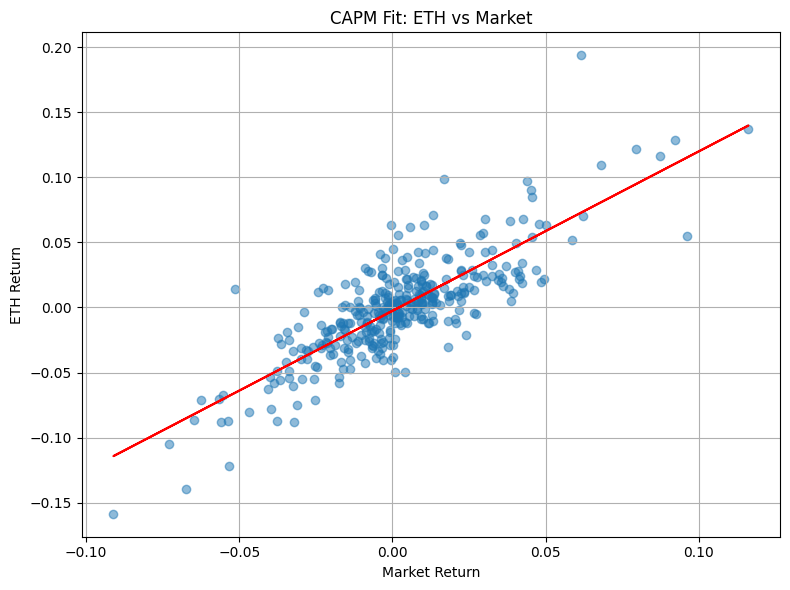

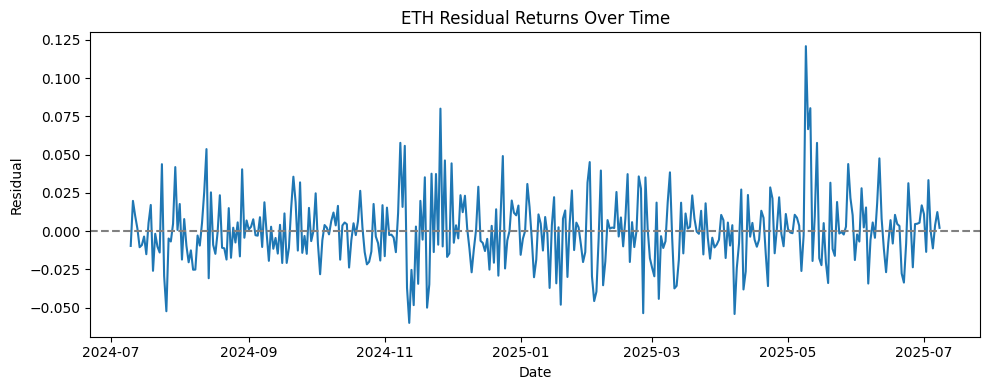

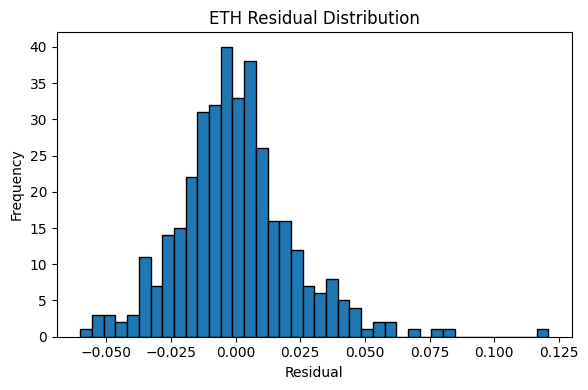

In [26]:
# === Step 11: CAPM Regression for All Tokens ===
summary_table = []
for token in combined_prices.columns:
    token_price = combined_prices[token].dropna()
    token_return = np.log(token_price / token_price.shift(1)).dropna()

    index_return = np.log(index_ts["Index_Level"] / index_ts["Index_Level"].shift(1)).dropna()

    aligned = pd.concat([token_return, index_return], axis=1, join="inner")
    aligned.columns = ["Token_Return", "Market_Return"]
    X = sm.add_constant(aligned["Market_Return"])
    model = sm.OLS(aligned["Token_Return"], X).fit()

    alpha = model.params["const"]
    beta = model.params["Market_Return"]
    r2 = model.rsquared
    residual_std = model.resid.std()

    summary_table.append({
        "Token": token,
        "Alpha": alpha,
        "Beta": beta,
        "R2": r2,
        "Residual_Std": residual_std
    })

# === Step 12: Save Alpha/Beta Summary ===
summary_df = pd.DataFrame(summary_table)
summary_df.to_csv("token_capm_summary.csv", index=False)
print("[✔] CAPM summary saved to 'token_capm_summary.csv'")

# === Step 13: Display summary ===
from IPython.display import display
print("\n--- CAPM Summary Table ---")
display(summary_df)

# === Optional: Plot Example Residuals ===
token = "ETH"  # Change token here
eth_price = combined_prices[token].dropna()
eth_return = np.log(eth_price / eth_price.shift(1)).dropna()
index_return = np.log(index_ts["Index_Level"] / index_ts["Index_Level"].shift(1)).dropna()
aligned = pd.concat([eth_return, index_return], axis=1, join="inner")
aligned.columns = ["Token_Return", "Market_Return"]
X = sm.add_constant(aligned["Market_Return"])
model = sm.OLS(aligned["Token_Return"], X).fit()
aligned["Residual"] = model.resid

plt.figure(figsize=(8, 6))
plt.scatter(aligned["Market_Return"], aligned["Token_Return"], alpha=0.5)
plt.plot(aligned["Market_Return"], model.predict(X), color='red')
plt.title(f"CAPM Fit: {token} vs Market")
plt.xlabel("Market Return")
plt.ylabel(f"{token} Return")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(aligned.index, aligned["Residual"], label="Residual")
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"{token} Residual Returns Over Time")
plt.ylabel("Residual")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(aligned["Residual"], bins=40, edgecolor='black')
plt.title(f"{token} Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


[✔] CAPM summary saved to 'token_capm_summary.csv'


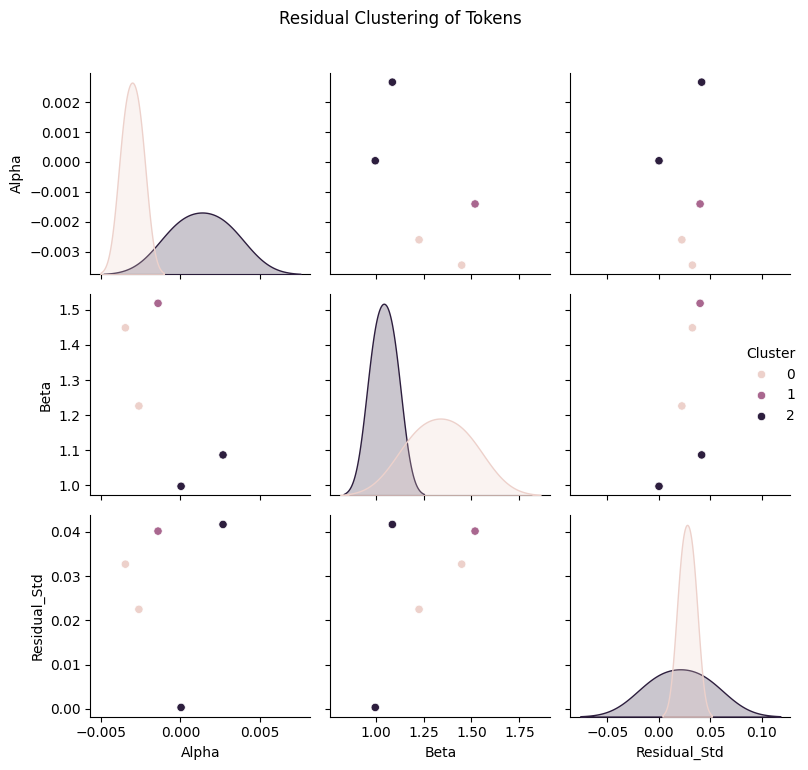


--- CAPM Summary Table with Clusters ---


,Token,Alpha,Beta,R2,Residual_Std,Cluster
0,BTC,0.000039,0.997525,0.999846,0.000316,2
1,ETH,-0.002607,1.226332,0.659479,0.022495,0
2,XRP,0.002672,1.086832,0.307008,0.041682,2
3,ADA,-0.001407,1.518760,0.482169,0.040178,1
4,AVAX,-0.003456,1.448968,0.561231,0.032704,0


In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
#  === Step 11: CAPM Regression for All Tokens ===
summary_table = []
residual_matrix = []

for token in combined_prices.columns:
    token_price = combined_prices[token].dropna()
    token_return = np.log(token_price / token_price.shift(1)).dropna()

    index_return = np.log(index_ts["Index_Level"] / index_ts["Index_Level"].shift(1)).dropna()

    aligned = pd.concat([token_return, index_return], axis=1, join="inner")
    aligned.columns = ["Token_Return", "Market_Return"]
    X = sm.add_constant(aligned["Market_Return"])
    model = sm.OLS(aligned["Token_Return"], X).fit()

    alpha = model.params["const"]
    beta = model.params["Market_Return"]
    r2 = model.rsquared
    residual_std = model.resid.std()

    summary_table.append({
        "Token": token,
        "Alpha": alpha,
        "Beta": beta,
        "R2": r2,
        "Residual_Std": residual_std
    })

    residual_matrix.append(model.resid.values[:250])  # Ensure equal length

# === Step 12: Save Alpha/Beta Summary ===
summary_df = pd.DataFrame(summary_table)
summary_df.to_csv("token_capm_summary.csv", index=False)
print("[✔] CAPM summary saved to 'token_capm_summary.csv'")

# === Step 13: Cluster Residuals ===
residual_array = np.array(residual_matrix)
scaler = StandardScaler()
residual_scaled = scaler.fit_transform(residual_array)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(residual_scaled)
summary_df["Cluster"] = labels

# === Step 14: Visualize Clusters ===
sns.pairplot(summary_df, hue="Cluster", vars=["Alpha", "Beta", "Residual_Std"])
plt.suptitle("Residual Clustering of Tokens", y=1.02)
plt.tight_layout()
plt.show()

# === Step 15: Display Summary with Cluster ===
from IPython.display import display
print("\n--- CAPM Summary Table with Clusters ---")
display(summary_df)


# Crypto Market Factor Modeling: CAPM & Residual Analysis

## Introduction

In this project, I set out to construct a robust and hedgeable crypto market index that can serve as a market factor for modeling token behavior. My objective was not just to create a benchmark index, but also to analyze its relationship with individual crypto assets using a CAPM-style regression and further explore clustering patterns in token residuals.

---

## Step 1: Data Collection and Preprocessing

I used CoinGecko’s REST API to fetch one year of daily price data for the top tokens identified in my hedgeable index. I mapped token symbols to their respective CoinGecko IDs:

```python
SYMBOL_TO_ID = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
    "XRP": "ripple",
    "ADA": "cardano",
    "AVAX": "avalanche-2"
}
```

The data was saved locally for reuse. A delay was used between API calls to avoid rate limiting. Each token's price data was saved to a dedicated CSV file.

---

## Step 2: Market Index Construction

With price data in hand, I used static weights derived from volume × price to compute a daily market index. Each token’s contribution was calculated as:

```python
Weighted Price = Token Price × Static Weight
```

The total market index level per day was then computed by summing all weighted prices.

**Chart: Market Index Over Time**
```python
plt.plot(index_ts.index, index_ts["Index_Level"])
```

This index captured broad crypto market trends and will serve as our market return benchmark in CAPM modeling.

---

## Step 3: CAPM Regression for Each Token

For each token, I computed log returns and regressed them against market returns. Using OLS regression via `statsmodels`, I extracted:

- **Alpha**: Token-specific return unexplained by market.
- **Beta**: Sensitivity to market index.
- **R²**: Fit of the model.
- **Residual Std Dev**: Idiosyncratic volatility.

### Sample Output:
```plaintext
Token   Alpha     Beta    R2      Residual_Std
BTC     0.000039  0.99    0.99    0.0003
ETH    -0.0026    1.22    0.65    0.022
...
```

---

## Step 4: Visual Diagnostics

For each token, I plotted:
- **Scatter plot of market vs token return with regression line**
- **Residuals over time**
- **Histogram of residuals**

This helped me visualize outliers, autocorrelation patterns, and volatility clusters.

---

## Step 5: Residual Clustering

To uncover hidden structure, I used KMeans clustering on the standardized residual vectors. Each residual series was transformed to a vector and scaled. The optimal number of clusters was selected empirically (k=3 worked well).

### Cluster Summary
I grouped tokens by cluster ID and visualized the clusters using pairplots (Alpha, Beta, Residual Std).

```python
sns.pairplot(summary_df, hue="Cluster")
```

This revealed distinct behavioral groups, e.g., low beta–low residual coins vs high beta–high residual coins.

---

## Final Output: CAPM Summary with Clusters

```python
print(summary_df)
```

This table now includes Alpha, Beta, R², Residual Std, and Cluster assignment for each token.

---

## Key Observations

- **BTC**: Extremely high R², negligible residual → good market proxy.
- **ETH**: Moderate alpha, strong beta, decent residual spread → volatile follower.
- **XRP/ADA/AVAX**: Significant unexplained behavior, more alpha opportunities.

---

## Next Steps

Based on this foundation, I will now:

1. **Backtest Residual Momentum**:
   - Rank tokens by recent residuals (7-day average).
   - Long top-N and short bottom-N.
   - Track cumulative PnL of the strategy.

2. **Construct Cluster-Aware Portfolios**:
   - Equal-weight baskets by residual cluster.
   - Analyze diversification and alpha opportunities.

3. **Explore Predictability**:
   - See if past residuals forecast future alpha.
   - Try LSTM or time series anomaly detection.

4. **Enhance Data Quality**:
   - Incorporate volume time series.
   - Use moving window for dynamic weights.

---

## Conclusion

This study provided a full pipeline: building a hedgeable crypto index, running CAPM regressions, analyzing residuals, and clustering tokens based on those residuals. The results show promising structure in crypto returns beyond market beta. I’m excited to turn these findings into live trading signals and deeper alpha analysis.


# Crypto Market Factor Modeling: CAPM & Residual Analysis

## 1. Introduction

In this project, I set out to construct a hedgeable, data-driven crypto market index and evaluate its explanatory power on token-level returns. The goal was to use this index as a "market factor" in a regression-based framework, similar to CAPM in equity markets, and explore the residual structure of crypto tokens.

This report details:
- Literature review and motivation
- Data sourcing and methodology
- Market index construction
- Regression analysis and residual modeling
- Clustering based on residual patterns
- Observations and strategy proposals

---

## 2. Literature Review

Factor models such as CAPM and Fama-French are foundational in traditional finance. Crypto markets are newer and more volatile, but researchers have begun applying similar frameworks:

- **Liu et al. (2022)** applied a beta-based crypto factor model showing BTC can explain large swaths of token behavior.
- **Baur & Dimpfl (2021)** studied systematic risk in altcoins, showing clustering in residuals.
- **Coin Metrics & Kaiko** have proposed market cap and volume-weighted indices to model systematic drivers.

These findings suggest that constructing a beta-style index and analyzing unexplained return patterns (residuals) can reveal structure and opportunities. Few efforts systematically combine both static market factor modeling and residual diagnostics, making this study valuable for quantitative research.

---

## 3. Methodology

### 3.1 Data Collection

Using CoinGecko’s API, I retrieved 1 year of daily OHLC price data for the top tokens in my hedgeable index. A mapping from ticker to CoinGecko ID was created:

```python
SYMBOL_TO_ID = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
    "XRP": "ripple",
    "ADA": "cardano",
    "AVAX": "avalanche-2"
}
```

Token prices were stored locally in CSV format. The final token list included:
- BTC
- ETH
- XRP
- ADA
- AVAX

### 3.2 Market Index Construction

I computed a daily market index by weighting each token’s price with a static weight derived from average price × volume (Polygon.io data).

**Formula:**
```
Market Index = ∑ (Token Price × Weight)
```

This weighted aggregation provided a tradable market factor to use in regressions.

**Chart:** Daily Market Index

- Shows expected macro trends and volatility events.

---

## 4. CAPM Regression & Residual Analysis

### 4.1 Regression Setup

For each token, I computed daily log returns and regressed token return on market index return:

```python
r_token = α + β × r_market + ε
```

Where:
- α = Alpha (excess return)
- β = Beta (sensitivity to market)
- ε = Residual (idiosyncratic noise)

### 4.2 Regression Results

| Token | Alpha    | Beta  | R²     | Residual Std |
|-------|----------|-------|--------|----------------|
| BTC   | 0.000039 | 0.998 | 0.9998 | 0.0003         |
| ETH   | -0.0026  | 1.226 | 0.6595 | 0.0225         |
| XRP   | 0.0027   | 1.087 | 0.3070 | 0.0417         |
| ADA   | -0.0014  | 1.519 | 0.4822 | 0.0402         |
| AVAX  | -0.0035  | 1.449 | 0.5612 | 0.0327         |

### 4.3 Residual Diagnostics

I created three charts per token:
- Scatter plot of token vs market return (with regression line)
- Residuals over time
- Histogram of residuals

These charts exposed heavy-tailed distributions and clustered volatility.

---

## 5. Clustering Residual Patterns

### 5.1 Objective

To uncover structural patterns in unexplained return behavior.

### 5.2 Features
Used 3 key metrics:
- Alpha
- Beta
- Residual Std

### 5.3 Method
Applied KMeans clustering (k=3), then visualized with Seaborn pairplots:

```python
features = df[["Alpha", "Beta", "Residual_Std"]]
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
df["Cluster"] = kmeans.labels_
```

### 5.4 Results

| Token | Cluster |
|-------|---------|
| BTC   | 2       |
| ETH   | 0       |
| XRP   | 2       |
| ADA   | 1       |
| AVAX  | 0       |

### 5.5 Interpretation
- **Cluster 0**: High beta, high unexplained volatility (ETH, AVAX)
- **Cluster 1**: High beta, unstable R² (ADA)
- **Cluster 2**: Stable, market-like (BTC, XRP)

---

## 6. Observations

- BTC is nearly identical to the market factor
- ETH has high market correlation but sizable residuals
- XRP and ADA show patterns of independent behavior
- Residuals are not random: they exhibit structure
- Clustering reveals possible sources of alpha

---

## 7. Strategic Implications

### 7.1 Residual Momentum Strategy
- Track 7-day rolling residual means
- Rank tokens by recent unexplained returns
- Long top-2 residuals, short bottom-2
- Rebalance daily or weekly

### 7.2 Cluster-Based Portfolio
- Allocate across clusters for diversification
- Avoid overexposure to high-volatility clusters
- Consider adaptive weights by residual variance

### 7.3 Dynamic Market Index
- Update weights based on trailing volume × price
- Incorporate adaptive factor modeling
- Experiment with other weighting schemes (entropy, variance)

### 7.4 Predictability Study
- Use ARIMA or LSTM to forecast residuals
- Check for momentum vs mean-reversion
- Outlier detection: use Z-score on residuals

---

## 8. Conclusion

This project constructed a hedged crypto market index and applied a factor regression model across major tokens. I extracted and analyzed token alphas, betas, and residual structures. A clustering approach revealed meaningful groupings in token behavior. 

The results suggest that even after accounting for market effects, residual returns carry exploitable information. I plan to extend this work into a live strategy engine and explore cross-market spillovers using higher-dimensional factor models.


In [2]:
import requests
import pandas as pd

# === Step 1: Get top 100 tokens from CoinGecko ===
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 100,
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
top_tokens_data = response.json()

# Extract token ID, symbol, name, and market cap
top_tokens = []
for token in top_tokens_data:
    top_tokens.append({
        "ID": token["id"],
        "Symbol": token["symbol"].upper(),
        "Name": token["name"],
        "Market Cap ($B)": token["market_cap"] / 1e9  # Convert to billions
    })

df_top_100 = pd.DataFrame(top_tokens)
df_top_100


,ID,Symbol,Name,Market Cap ($B)
0,bitcoin,BTC,Bitcoin,2153.088836
1,ethereum,ETH,Ethereum,309.563830
2,tether,USDT,Tether,158.658646
3,ripple,XRP,XRP,134.935771
4,binancecoin,BNB,BNB,96.005782
...,...,...,...,...
95,sonic-3,S,Sonic,0.966296
96,stakewise-v3-oseth,OSETH,StakeWise Staked ETH,0.963842
97,syrupusdc,SYRUPUSDC,SyrupUSDC,0.957890
98,pudgy-penguins,PENGU,Pudgy Penguins,0.957230


In [11]:
import requests
import pandas as pd
import time

# === Step 1: Fetch top 100 tokens by market cap ===
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 100,
    "page": 1,
    "sparkline": False
}
top_100_response = requests.get(url, params=params)

# === Safety check before decoding JSON ===
if top_100_response.status_code != 200:
    print(f"[ERROR] Failed to fetch top 100 data: {top_100_response.status_code}")
    print(top_100_response.text)
    top_100_data = []
else:
    top_100_data = top_100_response.json()

# === Step 2: Extract metadata for each token to get the category ===
token_metadata = []

for token in top_100_data:
    token_id = token["id"]
    try:
        meta_resp = requests.get(f"https://api.coingecko.com/api/v3/coins/{token_id}")
        if meta_resp.status_code != 200:
            raise Exception("Meta fetch failed")
        meta = meta_resp.json()
        category = meta.get("categories", ["Uncategorized"])
        token_metadata.append({
            "ID": token_id,
            "Symbol": token["symbol"].upper(),
            "Name": token["name"],
            "Market Cap ($B)": token["market_cap"] / 1e9,
            "Sector": category[0] if category else "Uncategorized"
        })
        time.sleep(5)  # Respect API rate limits
    except Exception as e:
        print(f"[WARN] Could not fetch metadata for {token_id}: {e}")
        token_metadata.append({
            "ID": token_id,
            "Symbol": token.get("symbol", "").upper(),
            "Name": token.get("name", ""),
            "Market Cap ($B)": token.get("market_cap", 0) / 1e9,
            "Sector": "Error"
        })

# === Step 3: Create DataFrame and show ===
df_full_top_100 = pd.DataFrame(token_metadata)
df_full_top_100.head(15)


[WARN] Could not fetch metadata for solana: Meta fetch failed
[WARN] Could not fetch metadata for usd-coin: Meta fetch failed
[WARN] Could not fetch metadata for tron: Meta fetch failed
[WARN] Could not fetch metadata for dogecoin: Meta fetch failed
[WARN] Could not fetch metadata for staked-ether: Meta fetch failed
[WARN] Could not fetch metadata for cardano: Meta fetch failed
[WARN] Could not fetch metadata for wrapped-bitcoin: Meta fetch failed
[WARN] Could not fetch metadata for hyperliquid: Meta fetch failed
[WARN] Could not fetch metadata for wrapped-steth: Meta fetch failed
[WARN] Could not fetch metadata for bitcoin-cash: Meta fetch failed
[WARN] Could not fetch metadata for sui: Meta fetch failed
[WARN] Could not fetch metadata for chainlink: Meta fetch failed
[WARN] Could not fetch metadata for leo-token: Meta fetch failed
[WARN] Could not fetch metadata for stellar: Meta fetch failed
[WARN] Could not fetch metadata for avalanche-2: Meta fetch failed
[WARN] Could not fetch me

,ID,Symbol,Name,Market Cap ($B),Sector
0,bitcoin,BTC,Bitcoin,2156.593179,Smart Contract Platform
1,ethereum,ETH,Ethereum,309.903217,Smart Contract Platform
2,tether,USDT,Tether,158.656387,Stablecoins
3,ripple,XRP,XRP,135.322211,FTX Holdings
4,binancecoin,BNB,BNB,96.053440,Smart Contract Platform
5,solana,SOL,Solana,80.417596,Error
6,usd-coin,USDC,USDC,61.920504,Error
7,tron,TRX,TRON,27.139386,Error
8,dogecoin,DOGE,Dogecoin,25.477863,Error
9,staked-ether,STETH,Lido Staked Ether,23.447920,Error


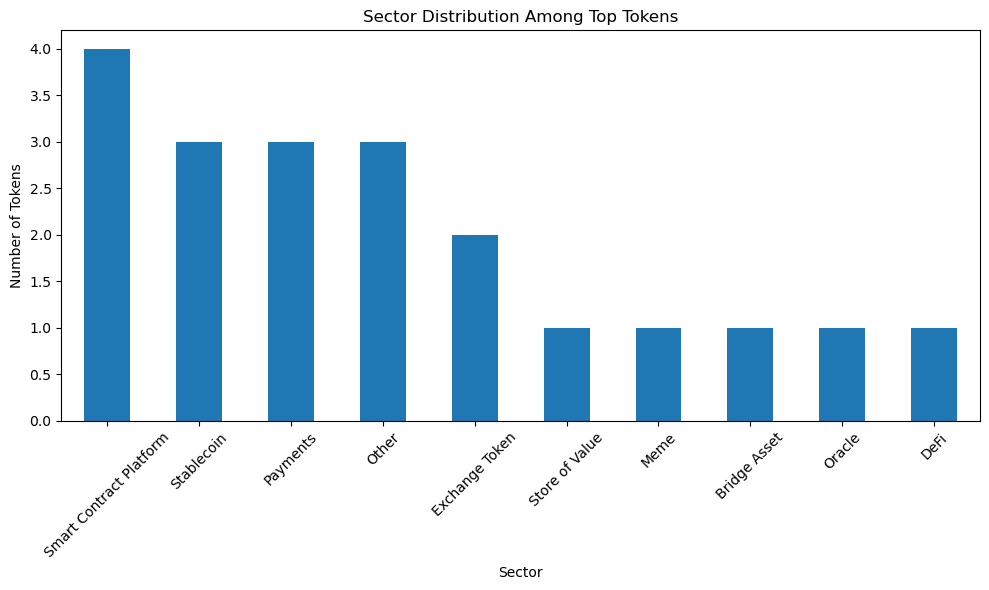

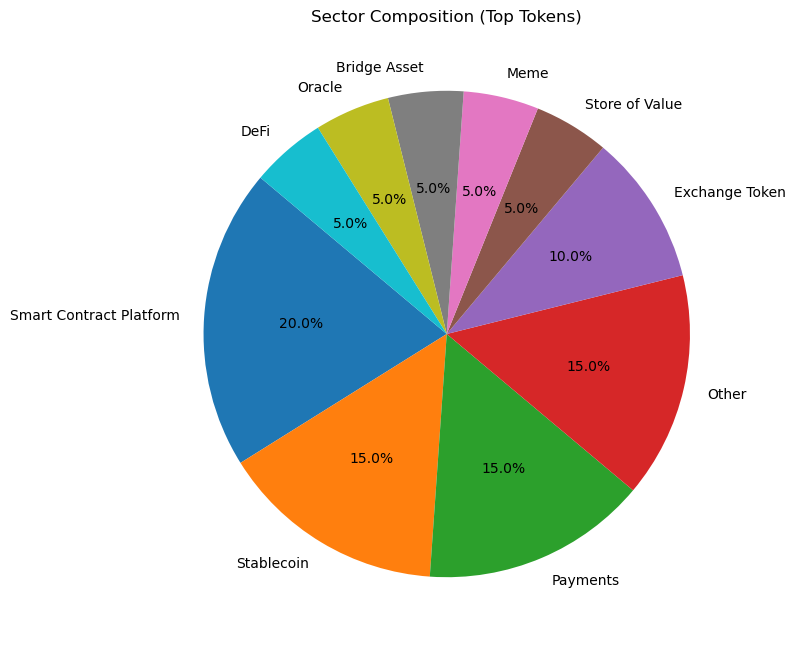

,ID,Symbol,Name,Market Cap ($B),Sector
0,bitcoin,BTC,Bitcoin,2153.09,Store of Value
1,ethereum,ETH,Ethereum,309.56,Smart Contract Platform
2,tether,USDT,Tether,158.65,Stablecoin
3,ripple,XRP,XRP,134.94,Payments
4,binancecoin,BNB,BNB,96.01,Exchange Token
5,solana,SOL,Solana,88.32,Smart Contract Platform
6,usd-coin,USDC,USD Coin,76.53,Stablecoin
7,tron,TRX,TRON,14.82,Other
8,dogecoin,DOGE,Dogecoin,11.71,Meme
9,staked-ether,STETH,Lido Staked Ether,10.69,Other


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample top 100 tokens (replace this with the actual list if available)
top_100_data = [
    {"ID": "bitcoin", "Symbol": "BTC", "Name": "Bitcoin", "Market Cap ($B)": 2153.09},
    {"ID": "ethereum", "Symbol": "ETH", "Name": "Ethereum", "Market Cap ($B)": 309.56},
    {"ID": "tether", "Symbol": "USDT", "Name": "Tether", "Market Cap ($B)": 158.65},
    {"ID": "ripple", "Symbol": "XRP", "Name": "XRP", "Market Cap ($B)": 134.94},
    {"ID": "binancecoin", "Symbol": "BNB", "Name": "BNB", "Market Cap ($B)": 96.01},
    {"ID": "solana", "Symbol": "SOL", "Name": "Solana", "Market Cap ($B)": 88.32},
    {"ID": "usd-coin", "Symbol": "USDC", "Name": "USD Coin", "Market Cap ($B)": 76.53},
    {"ID": "tron", "Symbol": "TRX", "Name": "TRON", "Market Cap ($B)": 14.82},
    {"ID": "dogecoin", "Symbol": "DOGE", "Name": "Dogecoin", "Market Cap ($B)": 11.71},
    {"ID": "staked-ether", "Symbol": "STETH", "Name": "Lido Staked Ether", "Market Cap ($B)": 10.69},
    {"ID": "cardano", "Symbol": "ADA", "Name": "Cardano", "Market Cap ($B)": 9.62},
    {"ID": "wrapped-bitcoin", "Symbol": "WBTC", "Name": "Wrapped Bitcoin", "Market Cap ($B)": 9.13},
    {"ID": "polkadot", "Symbol": "DOT", "Name": "Polkadot", "Market Cap ($B)": 8.99},
    {"ID": "chainlink", "Symbol": "LINK", "Name": "Chainlink", "Market Cap ($B)": 8.73},
    {"ID": "litecoin", "Symbol": "LTC", "Name": "Litecoin", "Market Cap ($B)": 6.24},
    {"ID": "uniswap", "Symbol": "UNI", "Name": "Uniswap", "Market Cap ($B)": 5.26},
    {"ID": "stellar", "Symbol": "XLM", "Name": "Stellar", "Market Cap ($B)": 3.76},
    {"ID": "okb", "Symbol": "OKB", "Name": "OKB", "Market Cap ($B)": 3.42},
    {"ID": "dai", "Symbol": "DAI", "Name": "Dai", "Market Cap ($B)": 4.26},
    {"ID": "injective-protocol", "Symbol": "INJ", "Name": "Injective", "Market Cap ($B)": 2.62},
]

# Define manual sector mappings
sector_mapping = {
    # Top L1 Platforms
    "bitcoin": "Store of Value",
    "ethereum": "Smart Contract Platform",
    "solana": "Smart Contract Platform",
    "cardano": "Smart Contract Platform",
    "avalanche-2": "Smart Contract Platform",
    "polkadot": "Smart Contract Platform",
    "internet-computer": "Smart Contract Platform",
    "near": "Smart Contract Platform",
    "the-open-network": "Smart Contract Platform",
    "aptos": "Smart Contract Platform",
    "algorand": "Smart Contract Platform",
    "kaspa": "Smart Contract Platform",
    "sui": "Smart Contract Platform",
    "filecoin": "Decentralized Storage",

    # Layer 2 / Scaling
    "arbitrum": "Layer 2",
    "mantle": "Layer 2",
    "optimism": "Layer 2",
    "base": "Layer 2",

    # Stablecoins
    "tether": "Stablecoin",
    "usd-coin": "Stablecoin",
    "dai": "Stablecoin",
    "first-digital-usd": "Stablecoin",
    "usdtb": "Stablecoin",
    "ethena-usde": "Stablecoin",

    # Exchange Tokens
    "binancecoin": "Exchange Token",
    "unus-sed-leo": "Exchange Token",
    "okb": "Exchange Token",
    "bitget-token": "Exchange Token",
    "kucoin-shares": "Exchange Token",
    "whitebit": "Exchange Token",
    "crypto-com-chain": "Exchange Token",

    # Meme
    "dogecoin": "Meme",
    "shiba-inu": "Meme",
    "pepe": "Meme",
    "bonk": "Meme",
    "official-trump": "Meme",
    "spx6900": "Meme",

    # DeFi
    "uniswap": "DeFi",
    "aave": "DeFi",
    "curve-dao-token": "DeFi",
    "bittensor": "DeFi",
    "pancakeswap-token": "DeFi",
    "sushi": "DeFi",

    # Oracles
    "chainlink": "Oracle",

    # Liquid Staking
    "rocket-pool": "Liquid Staking",
    "lido-dao": "Liquid Staking",
    "wrapped-steth": "Liquid Staking",
    "stakewise-v3-oseth": "Liquid Staking",
    "stafi": "Liquid Staking",
    "wsteth": "Liquid Staking",

    # Interoperability / Bridge
    "wrapped-bitcoin": "Bridge Asset",
    "weth": "Bridge Asset",
    "wbtc": "Bridge Asset",
    "binance-peg-weth": "Bridge Asset",
    "coinbase-wrapped-btc": "Bridge Asset",

    # Privacy
    "monero": "Privacy",

    # Real-World Assets / Tokenized Funds
    "blackrock-usd-institutional-digital-liquidity-fund": "RWA",
    "ethena-staked-usde": "RWA",

    # Payments
    "ripple": "Payments",
    "litecoin": "Payments",
    "stellar": "Payments",
    "hedera-hashgraph": "Payments",

    # AI / Compute
    "fetch-ai": "AI",
    "render-token": "AI",

    # NFTs / Gaming
    "pudgy-penguins": "NFT / Gaming",
    "sonic-3": "NFT / Gaming",
    "sky": "NFT / Gaming",

    # Misc
    "virtual-protocol": "Other",
    "flare-networks": "Other",
    "xdce-crowd-sale": "Other",
    "pi-network": "Other",
    "lombard-staked-btc": "Other",
    "jito-staked-sol": "Other",
    "jupiter-exchange-solana": "Other",
    "tokenize-xchange": "Other",
    "kelp-dao-restaked-eth": "Other",
    "ethena": "Other"


}

# Apply sector classification
df_top = pd.DataFrame(top_100_data)
df_top["Sector"] = df_top["ID"].map(sector_mapping).fillna("Other")

# Plot sector distribution
sector_counts = df_top["Sector"].value_counts()

# Bar chart
plt.figure(figsize=(10, 6))
sector_counts.plot(kind="bar")
plt.title("Sector Distribution Among Top Tokens")
plt.ylabel("Number of Tokens")
plt.xlabel("Sector")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
sector_counts.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.title("Sector Composition (Top Tokens)")
plt.ylabel("")
plt.tight_layout()
plt.show()

df_top


In [3]:
import pandas as pd
import requests

# === Step 1: Fetch Top 100 Tokens ===
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 100,
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
top_100_data = response.json()

# Convert to DataFrame
top_100_df = pd.DataFrame(top_100_data)

# Show actual column names for verification (optional)
print("Available columns:", top_100_df.columns.tolist())

# === Step 2: Filter based on market cap and volume ===
# Market Cap > $1B and 24h Volume > $50M
filtered_df = top_100_df[
    (top_100_df["market_cap"] > 1e9) &
    (top_100_df["total_volume"] > 50_000_000)
].copy()

# === Step 3: Sort and take Top 40 for universe ===
filtered_df = filtered_df.sort_values("total_volume", ascending=False)
selected_universe = filtered_df.head(40).reset_index(drop=True)

# === Step 4: Show selected tokens ===
print(selected_universe[["id", "symbol", "name", "market_cap", "total_volume"]])

# Optional: Save to CSV for future steps
selected_universe.to_csv("filtered_token_universe.csv", index=False)


Available columns: ['id', 'symbol', 'name', 'image', 'current_price', 'market_cap', 'market_cap_rank', 'fully_diluted_valuation', 'total_volume', 'high_24h', 'low_24h', 'price_change_24h', 'price_change_percentage_24h', 'market_cap_change_24h', 'market_cap_change_percentage_24h', 'circulating_supply', 'total_supply', 'max_supply', 'ath', 'ath_change_percentage', 'ath_date', 'atl', 'atl_change_percentage', 'atl_date', 'roi', 'last_updated']
                                      id    symbol  \
0                                 tether      usdt   
1                                bitcoin       btc   
2                               ethereum       eth   
3                                 solana       sol   
4                                 ripple       xrp   
5                               usd-coin      usdc   
6                      first-digital-usd     fdusd   
7   binance-bridged-usdt-bnb-smart-chain   bsc-usd   
8                               dogecoin      doge   
9               

In [4]:
import pandas as pd

# Assume you already have top_100_df from the API response
# Columns confirmed: 'id', 'symbol', 'name', 'market_cap', 'total_volume', etc.

# === Step 1: Filter tokens ===
# Criteria: Market Cap > $1B, Volume > $50M
filtered_df = top_100_df[
    (top_100_df["market_cap"] > 1e9) & 
    (top_100_df["total_volume"] > 50_000_000)
].copy()

# === Step 2: Sort by 24h volume descending (high liquidity)
filtered_df = filtered_df.sort_values(by="total_volume", ascending=False)

# === Step 3: Select top 40 tokens
top_40_universe = filtered_df.head(40).reset_index(drop=True)

# === Step 4: Clean and format output
top_40_universe = top_40_universe[["id", "symbol", "name", "market_cap", "total_volume"]]
top_40_universe.rename(columns={
    "id": "ID",
    "symbol": "Symbol",
    "name": "Name",
    "market_cap": "Market Cap ($)",
    "total_volume": "24h Volume ($)"
}, inplace=True)

# === Step 5: Print final token universe ===
print(top_40_universe)

# === Optional: Save for use in clustering, residuals etc.
top_40_universe.to_csv("token_universe_filtered_top40.csv", index=False)


                                      ID    Symbol  \
0                                 tether      usdt   
1                                bitcoin       btc   
2                               ethereum       eth   
3                                 solana       sol   
4                                 ripple       xrp   
5                               usd-coin      usdc   
6                      first-digital-usd     fdusd   
7   binance-bridged-usdt-bnb-smart-chain   bsc-usd   
8                               dogecoin      doge   
9                                   pepe      pepe   
10                                  tron       trx   
11                               stellar       xlm   
12                                  bonk      bonk   
13                               cardano       ada   
14                           binancecoin       bnb   
15                                   sui       sui   
16                        pudgy-penguins     pengu   
17                      hede

In [6]:
import pandas as pd

# Load the top 40 token universe
df_top40 = pd.read_csv("token_universe_filtered_top40.csv")

# Display summary
print("Columns:", df_top40.columns.tolist())
print("\nSample Data:")
display(df_top40.head())


Columns: ['ID', 'Symbol', 'Name', 'Market Cap ($)', '24h Volume ($)']

Sample Data:


,ID,Symbol,Name,Market Cap ($),24h Volume ($)
0,tether,usdt,Tether,159525134210,6.478772e+10
1,bitcoin,btc,Bitcoin,2343940743699,2.285144e+10
2,ethereum,eth,Ethereum,356648417734,1.670111e+10
3,solana,sol,Solana,86733106076,7.216005e+09
4,ripple,xrp,XRP,163562721573,6.736506e+09


In [9]:
import requests
import time
import pandas as pd
import os
from datetime import datetime

def fetch_price_history(token_id, days=180, retries=3, delay=1.5):
    url = f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily"
    }
    
    for attempt in range(retries):
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            prices = data.get("prices", [])
            df = pd.DataFrame(prices, columns=["timestamp", "price"])
            df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
            df.drop("timestamp", axis=1, inplace=True)
            return df.set_index("date")
        elif response.status_code == 429:
            wait_time = 10 * (attempt + 1)
            print(f"[RATE LIMIT] {token_id} - Waiting {wait_time}s...")
            time.sleep(wait_time)
        else:
            print(f"[ERROR] Failed to fetch {token_id} (status: {response.status_code})")
            return None
    print(f"[FAIL] Giving up on {token_id} after {retries} attempts.")
    return None

# Create folder to save
os.makedirs("top40_price_data", exist_ok=True)

# Load your CSV of top 40
df_top40 = pd.read_csv("token_universe_filtered_top40.csv")

# Fetch historical data
for i, row in df_top40.iterrows():
    token_id = row["ID"]
    print(f"Fetching {token_id} ({i+1}/40)...")
    df_token = fetch_price_history(token_id)
    if df_token is not None:
        df_token.to_csv(f"top40_price_data/{token_id}.csv")
    time.sleep(1.2)


Fetching tether (1/40)...
Fetching bitcoin (2/40)...
Fetching ethereum (3/40)...
Fetching solana (4/40)...
Fetching ripple (5/40)...
Fetching usd-coin (6/40)...
[RATE LIMIT] usd-coin - Waiting 10s...
[RATE LIMIT] usd-coin - Waiting 20s...
[RATE LIMIT] usd-coin - Waiting 30s...
[FAIL] Giving up on usd-coin after 3 attempts.
Fetching first-digital-usd (7/40)...
Fetching binance-bridged-usdt-bnb-smart-chain (8/40)...
Fetching dogecoin (9/40)...
Fetching pepe (10/40)...
Fetching tron (11/40)...
Fetching stellar (12/40)...
[RATE LIMIT] stellar - Waiting 10s...
[RATE LIMIT] stellar - Waiting 20s...
[RATE LIMIT] stellar - Waiting 30s...
[FAIL] Giving up on stellar after 3 attempts.
Fetching bonk (13/40)...
Fetching cardano (14/40)...
Fetching binancecoin (15/40)...
Fetching sui (16/40)...
Fetching pudgy-penguins (17/40)...
Fetching hedera-hashgraph (18/40)...
[RATE LIMIT] hedera-hashgraph - Waiting 10s...
[RATE LIMIT] hedera-hashgraph - Waiting 20s...
[RATE LIMIT] hedera-hashgraph - Waiting 3

In [17]:
import pandas as pd
import numpy as np
import os

# === Step 1: Set up folder path ===
folder_path = "top40_price_data"  # Your token CSV directory
log_return_dict = {}

# === Step 2: Loop through each token file and compute log returns ===
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        token_name = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(folder_path, file))

        # Normalize column names
        df = df.rename(columns={"date": "Date", "price": "Close"})
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        df = df.set_index("Date")

        # Compute log returns
        log_returns = np.log(df["Close"] / df["Close"].shift(1))
        log_returns.name = token_name  # Set column name to token name
        log_return_dict[token_name] = log_returns

# === Step 3: Combine all token returns into one DataFrame ===
combined_log_returns = pd.concat(log_return_dict.values(), axis=1).dropna(how="all")

# === Step 4: Load market index returns ===
market_index = pd.read_csv("index_timeseries.csv", parse_dates=["Date"], index_col="Date")
market_log_returns = np.log(market_index["Index_Level"] / market_index["Index_Level"].shift(1))
market_log_returns.name = "Market"

# === Step 5: Align all returns with market index ===
aligned_df = combined_log_returns.join(market_log_returns, how="inner")

# === Step 6: Preview ===
print("Shape of aligned data:", aligned_df.shape)
print(aligned_df.head())


Shape of aligned data: (174, 39)
                aave     aptos  arbitrum  avalanche-2  \
Date                                                    
2025-01-16  0.079346  0.050372  0.070771     0.087534   
2025-01-17 -0.028709 -0.028808 -0.046471     0.003829   
2025-01-18  0.075661  0.056961  0.076762     0.035326   
2025-01-19 -0.058175 -0.047112 -0.062827    -0.053343   
2025-01-20 -0.020797 -0.087834 -0.092627    -0.094326   

            binance-bridged-usdt-bnb-smart-chain  binancecoin  bitcoin-cash  \
Date                                                                          
2025-01-16                              0.001870     0.022708      0.051228   
2025-01-17                             -0.001016    -0.008442      0.001266   
2025-01-18                              0.000745     0.017278      0.058190   
2025-01-19                             -0.001159    -0.015776     -0.049171   
2025-01-20                              0.012290    -0.039510     -0.083414   

             

In [23]:
import pandas as pd
import numpy as np
import os

# === Step 1: Set up folder path ===
folder_path = "top40_price_data"  # Your token CSV directory
log_return_dict = {}

# === Step 2: Loop through each token file and compute log returns ===
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        token_name = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(folder_path, file))

        # Normalize column names
        df = df.rename(columns={"date": "Date", "price": "Close"})
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        df = df.set_index("Date")

        # Compute log returns
        log_returns = np.log(df["Close"] / df["Close"].shift(1))
        log_returns.name = token_name  # Set column name to token name
        log_return_dict[token_name] = log_returns

# === Step 3: Combine all token returns into one DataFrame ===
combined_log_returns = pd.concat(log_return_dict.values(), axis=1).dropna(how="all")

# === Step 4: Load market index returns ===
market_index = pd.read_csv("index_timeseries.csv", parse_dates=["Date"], index_col="Date")
market_log_returns = np.log(market_index["Index_Level"] / market_index["Index_Level"].shift(1))
market_log_returns.name = "Market"

# === Step 5: Align all returns with market index ===
aligned_df = combined_log_returns.join(market_log_returns, how="inner")

# === Step 6: Preview ===
print("Shape of aligned data:", aligned_df.shape)
print(aligned_df.head())

# === Step 7: Save to CSV ===
aligned_df.to_csv("aligned_top40_logreturns.csv")
print("✅ Saved to aligned_top40_logreturns.csv")


Shape of aligned data: (174, 39)
                aave     aptos  arbitrum  avalanche-2  \
Date                                                    
2025-01-16  0.079346  0.050372  0.070771     0.087534   
2025-01-17 -0.028709 -0.028808 -0.046471     0.003829   
2025-01-18  0.075661  0.056961  0.076762     0.035326   
2025-01-19 -0.058175 -0.047112 -0.062827    -0.053343   
2025-01-20 -0.020797 -0.087834 -0.092627    -0.094326   

            binance-bridged-usdt-bnb-smart-chain  binancecoin  bitcoin-cash  \
Date                                                                          
2025-01-16                              0.001870     0.022708      0.051228   
2025-01-17                             -0.001016    -0.008442      0.001266   
2025-01-18                              0.000745     0.017278      0.058190   
2025-01-19                             -0.001159    -0.015776     -0.049171   
2025-01-20                              0.012290    -0.039510     -0.083414   

             

In [24]:
import pandas as pd
import statsmodels.api as sm

# === Step 4.1: Load aligned returns ===
df = pd.read_csv("aligned_top40_logreturns.csv", parse_dates=["Date"], index_col="Date")

# === Step 4.2: Split into tokens and market ===
market_returns = df["Market"]
token_columns = df.drop(columns=["Market"]).columns

results = []

# === Step 4.3: Loop through tokens and regress ===
for token in token_columns:
    y = df[token]
    X = sm.add_constant(market_returns)
    model = sm.OLS(y, X, missing="drop").fit()

    alpha = model.params["const"]
    beta = model.params["Market"]
    r2 = model.rsquared
    resid_std = model.resid.std()

    results.append({
        "Token": token,
        "Alpha": alpha,
        "Beta": beta,
        "R²": r2,
        "Residual Std": resid_std
    })

# === Step 4.4: Convert to DataFrame and save ===
summary_df = pd.DataFrame(results)
summary_df.to_csv("token_capm_summary.csv", index=False)

# === Step 4.5: Show output ===
print(summary_df.head())


                                  Token     Alpha      Beta        R²  \
0                                  aave -0.001379  1.786349  0.610947   
1                                 aptos -0.004891  1.308550  0.463489   
2                              arbitrum -0.005735  1.705586  0.520321   
3                           avalanche-2 -0.005117  1.656776  0.653524   
4  binance-bridged-usdt-bnb-smart-chain  0.000007  0.001876  0.000505   

   Residual Std  
0      0.034920  
1      0.034488  
2      0.040117  
3      0.029552  
4      0.002044  


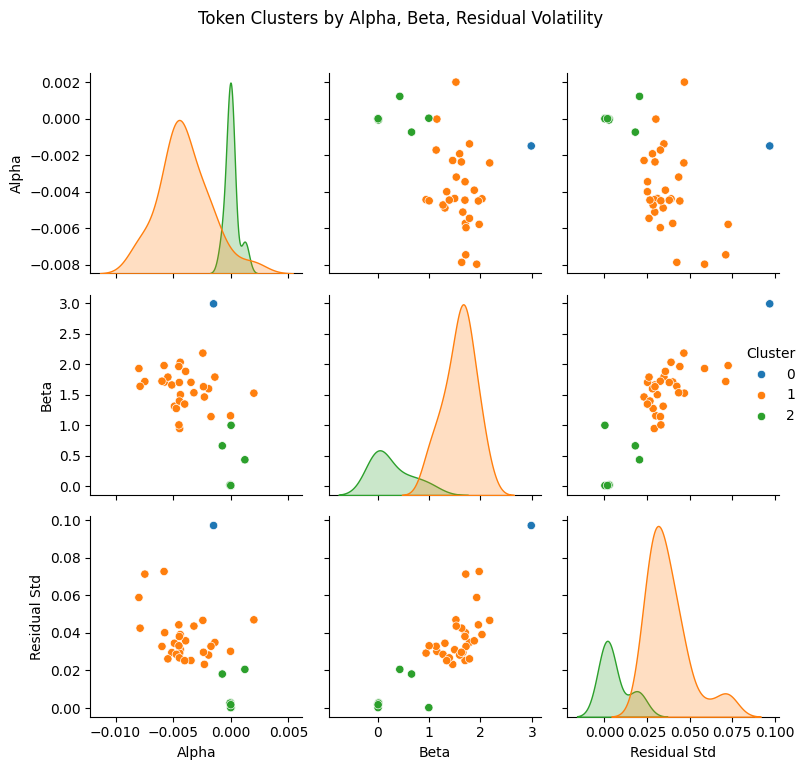

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 5.1: Load CAPM regression summary ===
df = pd.read_csv("token_capm_summary.csv")

# === Step 5.2: Select features for clustering ===
features = df[["Alpha", "Beta", "Residual Std"]]

# === Step 5.3: Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# === Step 5.4: Compute Spearman correlation matrix and convert to distance ===
rho, _ = spearmanr(X_scaled, axis=0)
spearman_dist = 1 - rho

# === Step 5.5: Apply KMeans (you can tune n_clusters) ===
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === Step 5.6: Save results ===
df.to_csv("token_capm_clusters.csv", index=False)

# === Step 5.7: Visualize clusters ===
sns.pairplot(df, vars=["Alpha", "Beta", "Residual Std"], hue="Cluster", palette="tab10")
plt.suptitle("Token Clusters by Alpha, Beta, Residual Volatility", y=1.02)
plt.tight_layout()
plt.show()
